# Coronavirus exploratory analysis
## *Hung Dinh*

This notebook demonstrates some exploratory analysis on the coronavirus COVID-19. The outbreak started in Wuhan (Hubei, China) in late December 2019, spread out quickly and then became global pandemic in March 2020.

I first carry out some analysis on the latest update summarized at https://www.worldometers.info/coronavirus/. A map showing countries with confirmed case is made for demonstration.

I then make a more detailed analysis in Vietnam. The data was collected by my wife since the first case detected.

### Anh đã sửa lại file này để em chạy cho dễ

Em chỉ cần ấn vào nút Run ở bên trên để chạy từng đoạn code. Chỗ nào không phải code thì nó sẽ tự bỏ qua.

Các bản đồ trong này đều zoom vào được, rê chuột vào từng địa điểm sẽ có thông tin.

# 0. Load hệ thống

In [1]:
! pip install plotly --upgrade -q
! pip install plotly -q
import plotly.express as px
import plotly.graph_objects as go

!pip install folium -q
import folium

import requests as requests
import pandas as pd
import matplotlib.dates as mdates # make time series for accumulative case
import matplotlib.pyplot as plt
%matplotlib inline
import json, urllib # extract location/country from geojson file

import numpy as np

# 1. Vietnam

### Load data and clean

In [2]:
df = pd.read_excel('https://raw.githubusercontent.com/nhohung/coronavirusmap/master/Covid-19.xlsx', skiprows = 1)

# df = df.drop(['Unnamed: 0', 'Unnamed: 12', 'Nơi mắc.1', 'Unnamed: 14'], axis = 1)  ### on IBM
df = df.drop(['Unnamed: 0', 'Hạng bay', 'Chuyến bay', 'Ghi chú'], axis = 1)          ### on CoLab

In [3]:
# drop a Nan row
df = df[df['TT'].isnull()==False]
# fill nationality
df['Quốc tịch'].fillna('Việt Nam', inplace = True)

### Summary by province

In [4]:
df1 = pd.DataFrame(df['Nơi mắc'].value_counts())

Make vertical bar plot

**Em muốn chỉnh kích thước hình, đổi tiêu đề, hay cỡ chữ to/bé thì em sửa thẳng vào code, anh chú thích ở đấy rồi.**

**Tốt nhất nên chỉnh từng lần một, nhỡ sai còn Command+Z được**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

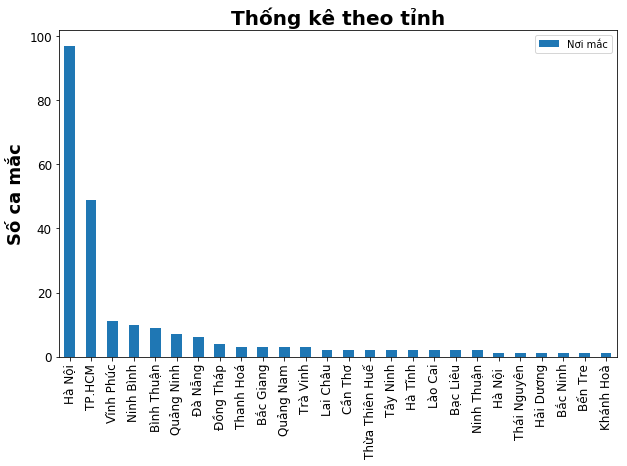

In [5]:
df1.plot(kind='bar', figsize=(10,6))   # chỉnh kích thước rộng x cao, đơn vị inches
plt.title('Thống kê theo tỉnh', fontweight = 'bold', fontsize = 20) # chỉnh font chữ tiêu đề
plt.ylabel("Số ca mắc", fontweight = 'bold', fontsize = 18)   # chỉnh font chữ chú thích trục tung
plt.yticks(fontsize = 12)   # chỉnh font chữ đơn vị trục tung
plt.xticks(fontsize = 12)   # chỉnh font chữ đơn vị trục hoành

Make horizontal bar plot:

(array([  0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 7 Text xticklabel objects>)

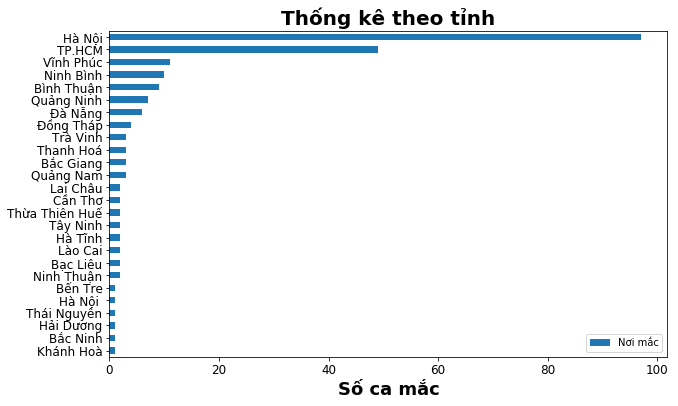

In [6]:
df1.sort_values(by='Nơi mắc', inplace = True)
ax = df1.plot(kind='barh', figsize=(10,6))  # chỉnh kích thước rộng x cao, đơn vị inches
plt.title('Thống kê theo tỉnh', fontweight = 'bold', fontsize = 20) # chỉnh font chữ tiêu đề
plt.xlabel("Số ca mắc", fontweight = 'bold', fontsize = 18)   # chỉnh font chữ chú thích trục tung
plt.yticks(fontsize = 12)   # chỉnh font chữ đơn vị trục tung
plt.xticks(fontsize = 12)   # chỉnh font chữ đơn vị trục hoành

#### Đoạn code dưới đây thống kê số ca nhiễm người nước ngoài và có yếu tố nước ngoài tại mỗi tỉnh thành, sắp xếp theo thứ tự như 2 biểu đồ ở trên.

Em chạy, nó sẽ hiện ra 1 cái bảng thì lấy đấy mà dùng, không cần phải đếm trong Excel, rất dễ bị sót

In [7]:
# Sắp xếp ca mắc
df1.sort_values(by='Nơi mắc', ascending=False, inplace = True)
df1.reset_index(inplace=True)
df1.columns=['Nơi mắc','Số ca']

In [8]:
# Tính số ca có yếu tố nước ngoài
df1nn = pd.DataFrame(df.groupby("Nơi mắc")["Nc ngoài"].sum())
df1nn["Nc ngoài"] = df1nn["Nc ngoài"].astype(int)
df1nn.columns=['Yếu tố NN']

# Tính số ca người nước ngoài
## Define func
def label_qt (row):
    if (row['Quốc tịch'] != 'Việt Nam') and (row['Quốc tịch'] != 'DHS'):
        return 1
    else:
        return 0
## apply func
df['qt'] = df.apply(label_qt, axis=1)
## sum
df1qt = pd.DataFrame(df.groupby("Nơi mắc")["qt"].sum())
df1qt["qt"] = df1qt["qt"].astype(int)
df1qt.columns=['Người NN']

In [9]:
tmp = pd.merge(df1, df1qt, left_on='Nơi mắc', right_on='Nơi mắc', how='left')
tmp = pd.merge(tmp, df1nn, left_on='Nơi mắc', right_on='Nơi mắc', how='left')
tmp

Nơi mắc  Số ca  Người NN  Yếu tố NN
0           Hà Nội     97         9         52
1           TP.HCM     49        21         30
2        Vĩnh Phúc     11         0          5
3        Ninh Bình     10         1          9
4       Bình Thuận      9         0          1
5       Quảng Ninh      7         4          7
6          Đà Nẵng      6         3          5
7        Đồng Tháp      4         0          4
8        Quảng Nam      3         3          3
9         Trà Vinh      3         0          3
10       Thanh Hoá      3         0          3
11       Bắc Giang      3         0          3
12        Lai Châu      2         0          0
13         Cần Thơ      2         0          2
14  Thừa Thiên Huế      2         2          2
15        Tây Ninh      2         0          2
16         Hà Tĩnh      2         0          2
17         Lào Cai      2         2          2
18        Bạc Liêu      2         0          2
19      Ninh Thuận      2         0          2
20        Bắc Ninh      1         0          1
21         Bến Tre      1         0          1
22         Hà Nội       1         0          0
23     Thái Nguyên      1         0          0
24       Hải Dương      1         1          1
25       Khánh Hoà      1         0          0

### Summary by country

In [10]:
df2 = df['Quốc tịch'].value_counts()

Text(0.5, 1.0, 'Thống kê theo quốc gia')

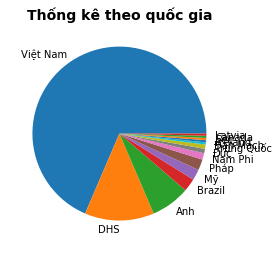

In [11]:
df2.plot(kind='pie', title='Thống kê theo quốc gia')
plt.ylabel('')
plt.title('Thống kê theo quốc gia', fontweight = 'bold', fontsize = 14) # chỉnh font chữ tiêu đề

### Thống kê số ca mắc theo thời gian

Plot accumulative case by time

In [12]:
# Count case in each day, then sort
df3 = pd.DataFrame(df['Ngày mắc'].value_counts().sort_index())

# Calculate cummulative sum by day
df3 = df3.cumsum()

# Make time series axis: fill in all date
idx = pd.date_range(min(df3.index), max(df3.index))

# Fill all date into data, assign zero values
df3 = df3.reindex(idx, fill_value=0)

# Replace zeros from previous date
df3 = df3.replace(to_replace=0, method='ffill')


Make a plot

_Nếu em không thích có đường kẻ trong biểu đồ thì ở dòng lệnh đầu tiên, em bỏ cái grid=True và dấu phẩy ngay trước đó đi_

(array([18283, 18293, 18322, 18353, 18354]),
 <a list of 5 Text xticklabel objects>)

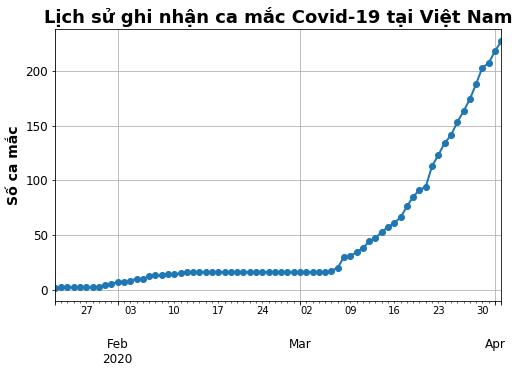

In [13]:
ax = df3.plot(linewidth=2, figsize=(8,5), marker = 'o', grid=True)
# ax.set_ylabel('Số ca mắc')
ax.get_legend().remove()

plt.title('Lịch sử ghi nhận ca mắc Covid-19 tại Việt Nam', fontweight = 'bold', fontsize = 18) # chỉnh font chữ tiêu đề
plt.ylabel("Số ca mắc", fontweight = 'bold', fontsize = 14)   # chỉnh font chữ chú thích trục tung
plt.yticks(fontsize = 12)   # chỉnh font chữ đơn vị trục tung
plt.xticks(fontsize = 12)   # chỉnh font chữ đơn vị trục hoành

### Thống kê số ca mắc mới trong ngày theo thời gian

In [14]:
# Count case in each day, then sort
df31 = pd.DataFrame(df['Ngày mắc'].value_counts().sort_index())

# Make time series axis: fill in all date
idx = pd.date_range(min(df31.index), max(df31.index))

# Fill all date into data, assign zero values
df31 = df31.reindex(idx, fill_value=0)

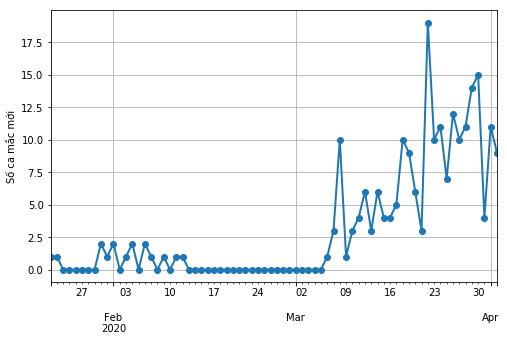

In [15]:
ax = df31.plot(linewidth=2, figsize=(8,5), marker = 'o', grid = True)
ax.set_ylabel('Số ca mắc mới')
ax.get_legend().remove()

### Visualize cases on map

Filter cases from Vietnam and summary by province

In [16]:
# df4 = df[df['Quốc tịch']=='Việt Nam']
df5 = df['Nơi mắc'].value_counts().rename_axis('province').reset_index(name='count')

Edit typos to match location id from geojson file

In [17]:
df5.province = df5.province.replace(to_replace='Khánh Hoà', value='Khánh Hòa')
df5.province = df5.province.replace(to_replace='Thanh Hoá', value='Thanh Hóa')
df5.province = df5.province.replace(to_replace='TP.HCM', value='TP. Hồ Chí Minh')
df5.province = df5.province.replace(to_replace='Huế', value='Thừa Thiên Huế')

Load geojson file. The file was originated from [opendevelopmentmekong](https://data.opendevelopmentmekong.net/dataset/999c96d8-fae0-4b82-9a2b-e481f6f50e12/resource/234169fb-ae73-4f23-bbd4-ff20a4fca401/download/diaphantinh.geojson) (no longer accessible).

In [18]:
state_geo = 'https://raw.githubusercontent.com/nhohung/coronavirusmap/master/diaphantinh.geojson'

f = urllib.request.urlopen(state_geo)
values = json.load(f)
f.close()

Extract provinces and create empty count for each

In [19]:
df6 = pd.DataFrame(columns=['province','count'])
for i in values['features']:
    df6 = df6.append({'province': i['properties']['ten_tinh'], 'count':0}, ignore_index=True)

Assign coronavirus cases to corresponding province

In [20]:
for row in df5.iterrows():
    cty = row[1]['province']
    df6.loc[df6['province']==cty, 'count'] = row[1]['count']

Convert count to numeric for plotting

In [21]:
df6["count"] = pd.to_numeric(df6["count"])

Make a map

In [22]:
fig = px.choropleth(df6, geojson=state_geo, color="count",
#                     colorbar_title = "Tổng số ca mắc",
                    locations="province",
                    featureidkey="properties.ten_tinh",
                    projection="mercator",
                    color_continuous_scale=[(0, 'rgb(255, 255, 255)'), (0.005, 'rgb(255, 255, 213)'), (0.1, "orange"), (1, "red")]
                   )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

_Một kiểu bản đồ khác, dự phòng_

In [23]:
m = folium.Map(location=[16, 106], tiles='stamenwatercolor', zoom_start=5)
m.choropleth(
    geo_data=state_geo,
    data=df6,
    columns=['province', 'count'],
    key_on='properties.ten_tinh',
    fill_color='YlOrRd',
    fill_opacity=1,
    line_opacity=1,
    legend_name='Number of cases',
#     highlight=True
)

m

/opt/conda/envs/Python36/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning:

The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.



### Summary by age

In [24]:
df7 = pd.DataFrame(df['Tuổi'])

In [25]:
df7["0-10"] = np.where(df7['Tuổi']<=10, 1, 0)
df7["10-18"] = np.where((df7['Tuổi']>10)&(df7['Tuổi']<=18), 1, 0)
df7["19-30"] = np.where((df7['Tuổi']>18)&(df7['Tuổi']<=30), 1, 0)
df7["31-40"] = np.where((df7['Tuổi']>30)&(df7['Tuổi']<=40), 1, 0)
df7["41-50"] = np.where((df7['Tuổi']>40)&(df7['Tuổi']<=50), 1, 0)
df7["51-60"] = np.where((df7['Tuổi']>50)&(df7['Tuổi']<=60), 1, 0)
df7[">60"] = np.where(df7['Tuổi']>60, 1, 0)

In [26]:
df8 = pd.DataFrame(df7.sum())
df8.drop(['Tuổi'], inplace = True)

In [27]:
tuoitotal = df8.sum(axis=0)
df8=df8/tuoitotal*100

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

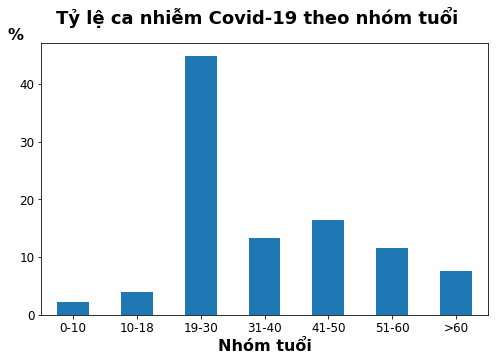

In [28]:
df8.plot(kind = 'bar', figsize=(8,5), rot=0, legend = False)
plt.suptitle('Tỷ lệ ca nhiễm Covid-19 theo nhóm tuổi', fontweight = 'bold', fontsize = 18)
plt.xlabel("Nhóm tuổi", fontweight = 'bold', fontsize = 16)
plt.ylabel("%", fontweight = 'bold', fontsize = 16, rotation = 0, position = (0,1))
plt.yticks(fontsize = 12)   # chỉnh font chữ đơn vị trục tung
plt.xticks(fontsize = 12)   # chỉnh font chữ đơn vị trục hoành

### Other plots

#### Thống kê theo số ca ngoại quốc

In [29]:
df9 = df[df['Quốc tịch']!='Việt Nam']

In [30]:
df10 = df9['Quốc tịch'].value_counts()

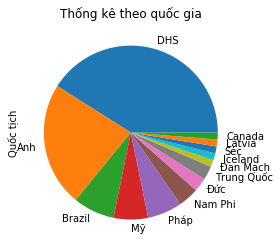

In [31]:
df10.plot(kind='pie', title='Thống kê theo quốc gia')

#### Thống kê theo giới tính của bệnh nhân Việt Nam

In [32]:
df = df.replace(to_replace='nam', value='Nam')

In [33]:
df11 = df[df['Quốc tịch']=='Việt Nam']['Giới tính'].value_counts()

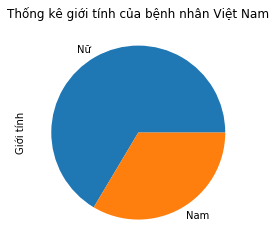

In [34]:
df11.plot(kind='pie', title='Thống kê giới tính của bệnh nhân Việt Nam')

#### Thống kê theo mức lây lan cộng đồng của bệnh nhân Việt Nam

In [35]:
df12 = df[df['Quốc tịch']=='Việt Nam']['F '].value_counts()

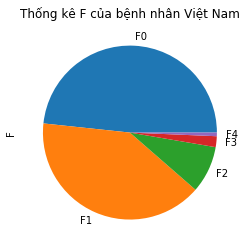

In [36]:
df12.plot(kind='pie', title='Thống kê F của bệnh nhân Việt Nam')

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

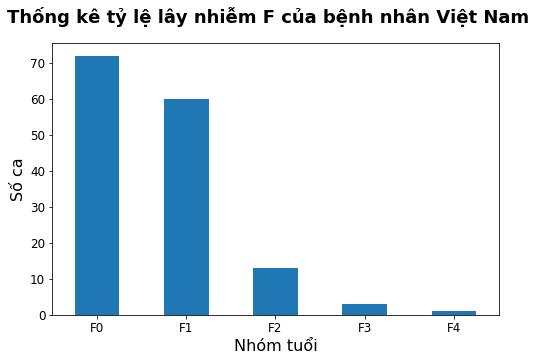

In [37]:
df12.plot.bar(stacked = True, figsize=(8,5), rot=0)
plt.suptitle('Thống kê tỷ lệ lây nhiễm F của bệnh nhân Việt Nam', fontweight = 'bold', fontsize = 18)
plt.xlabel("Nhóm tuổi", fontsize = 16)
plt.ylabel("Số ca", fontsize = 16)
plt.yticks(fontsize = 12)   # chỉnh font chữ đơn vị trục tung
plt.xticks(fontsize = 12)   # chỉnh font chữ đơn vị trục hoành

# 2. Thế giới (cập nhật theo worldometer)

In [38]:
# This cell no longer works :(
# tdf = pd.read_html('https://www.worldometers.info/coronavirus/')[0]  # Scrape web page
# Use this below:
r = requests.get('https://www.worldometers.info/coronavirus/', headers={'User-Agent': "Mozilla/5.0"})
tdf=pd.read_html(r.text)[0]

In [39]:
tdf = tdf[:-1] # remove last row (Total)
tdf.fillna(0, inplace = True)
tdf=tdf.rename(columns = {'Country,Other':'Country'})
tdf.sort_values(by='TotalCases', ascending=False, inplace = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

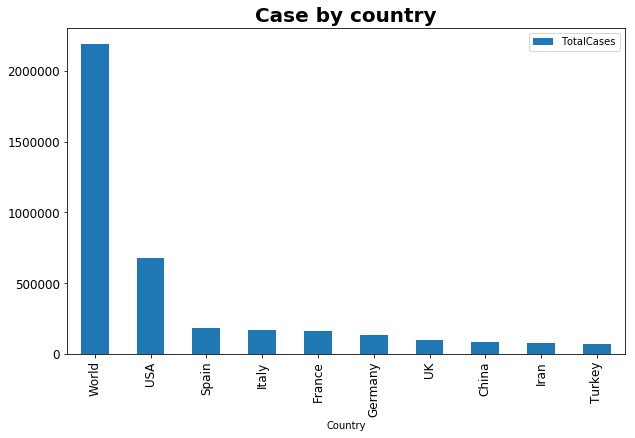

In [40]:
tdf.head(10).plot.bar("Country","TotalCases", figsize=(10,6))
plt.title('Case by country', fontweight = 'bold', fontsize = 20)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)

In [41]:
countrycode = pd.read_csv("https://raw.githubusercontent.com/nhohung/coronavirusmap/master/countrycode_fixname.csv")
countrycode['count']=0

In [42]:
for row in tdf.iterrows():
    cty = row[1]['Country']
    countrycode.loc[countrycode['country']==cty, 'count'] = row[1]['TotalCases']

### Create map

In [43]:
fig = px.choropleth(countrycode, locations="code",
                    color="count", # lifeExp is a column of gapminder
                    color_continuous_scale=[(0, 'rgb(255, 255, 255)'), (0.005, "yellow"), (0.05, "orange"), (1, "red")],
                    hover_name="country", # column to add to hover information
                    )
fig.show()

_Một kiểu bản đồ khác, dự phòng_

In [44]:
countmax = countrycode['count'].max()

In [45]:
fig = go.Figure(data = go.Choropleth(
    locations = countrycode['code'],
    z = countrycode['count'],
    text=countrycode['country'],
    colorscale=[
        # Let first 10% (0.1) of the values have color rgb(0, 0, 0)
        [0, "rgb(230, 229, 229)"],
        [1/countmax, "rgb(230, 229, 229)"],
        
        [1/countmax, "rgb(250, 242, 206)"],
        [9/countmax, "rgb(250, 242, 206)"],

        [9/countmax, "rgb(248, 231, 156)"],
        [99/countmax, "rgb(248, 231, 156)"],

        [99/countmax, "rgb(245, 218, 109)"],
        [999/countmax, "rgb(245, 218, 109)"],

        [999/countmax, "rgb(178, 145, 28)"],
        [9999/countmax, "rgb(178, 145, 28)"],

        [9999/countmax, "rgb(120, 98, 14)"],
        [1.0, "rgb(120, 98, 14)"]
    ],

))
fig.add_shape(
            type="rect",
            x0=0.2,
            y0=-0.1,
            x1=0.3,
            y1=-0.05,
            line=dict(
                color="rgb(250, 242, 206)",
            ),
        fillcolor="rgb(250,242,206)",
        )
fig.add_shape(
            type="rect",
            x0=0.3,
            y0=-0.1,
            x1=0.4,
            y1=-0.05,
            line=dict(
                color="rgb(248, 231, 156)",
            ),
        fillcolor="rgb(248, 231, 156)",
        )
fig.add_shape(
            type="rect",
            x0=0.4,
            y0=-0.1,
            x1=0.5,
            y1=-0.05,
            line=dict(
                color="rgb(245, 218, 109)",
            ),
        fillcolor="rgb(245, 218, 109)",
        )
fig.add_shape(
            type="rect",
            x0=0.5,
            y0=-0.1,
            x1=0.6,
            y1=-0.05,
            line=dict(
                color="rgb(178, 145, 28)",
            ),
        fillcolor="rgb(178, 145, 28)",
        )
fig.add_shape(
            type="rect",
            x0=0.6,
            y0=-0.1,
            x1=0.7,
            y1=-0.05,
            line=dict(
                color="rgb(120, 98, 14)",
            ),
        fillcolor="rgb(120, 98, 14)",
        )

fig.update_layout(
    annotations=[
        dict(
            x=0.24,
            y=-0.15,
            showarrow=False,
            text="1-9",
            xref="paper",
            yref="paper",
        ),
        dict(
            x=0.35,
            y=-0.15,
            showarrow=False,
            text="10-99",
            xref="paper",
            yref="paper",
        ),
        dict(
            x=0.45,
            y=-0.15,
            showarrow=False,
            text="100-999",
            xref="paper",
            yref="paper",
        ),
        dict(
            x=0.55,
            y=-0.15,
            showarrow=False,
            text="1,000-9,999",
            xref="paper",
            yref="paper",
        ),
        dict(
            x=0.65,
            y=-0.15,
            showarrow=False,
            text="10,000+",
            xref="paper",
            yref="paper",
        )
        
    ])

fig.update_layout(coloraxis_showscale=False)

fig.show()